In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import misc, fft
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
# Array functions

def print_size(array):
    """Print shape, data type and size in GiB of an array."""
    print(array.shape, array.dtype, '| total size:', array.nbytes/2**30, 'GiB')

def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice centered at zero with given pitch."""
    indices = np.arange(res, dtype=np.float32)
    return (indices - res/2 + 0.5) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Circle functions

def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return cp.sqrt(1.0 - cp.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (cp.sqrt(1.0 - cp.square(x)) * x + cp.arcsin(x))/2

def circle_box_area(x_interval, y_interval):
    """Return the area of the intersection of a box against the unit circle."""
    # Positive semicircle medial
    y_clipped = cp.clip(y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area = x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Positive semicircle lateral
    y_clipped = cp.clip(y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle medial
    y_clipped = cp.clip(-y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle lateral
    y_clipped = cp.clip(-y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    return area



# Light field functions

def spatial_display_to_eye(x_a, x_b, z_r, z_a, z_b, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_r, z_a, z_b, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_r, z_a, z_b, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_r, z_a, z_b, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

def take_2d(values, idx_x, idx_y):
    """Return values at given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x, clipped_idx_y]

def sample_2d_scene(scene_image, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f):
    # Compute coordinates
    x_a = compute_coordinates(res_a, size_a / res_a)[:, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, :]
    # Project display samples to the retina plane
    x_r_over_ab = spatial_display_to_eye(x_a, x_b, z_r, z_a, z_b, z_f)[0]
    # Compute corresponding indices on the retina
    idx_r_over_ab = compute_indices(x_r_over_ab, res_r, size_r / res_r)
    # Sample scene
    signal_ab = take_2d(scene_image, idx_r_over_ab[:, np.newaxis, :, np.newaxis], idx_r_over_ab[np.newaxis, :, np.newaxis, :])
    return signal_ab

def square_aperture(x_interval, y_interval, pupil_diameter):
    x_interval = cp.clip(x_interval * 2 / pupil_diameter, -1, 1)
    y_interval = cp.clip(y_interval * 2 / pupil_diameter, -1, 1)
    return cp.subtract(x_interval[..., 1], x_interval[..., 0]) * cp.subtract(y_interval[..., 1], y_interval[..., 0])

def round_aperture(x_interval, y_interval, pupil_diameter):
    return circle_box_area(x_interval * 2 / pupil_diameter, y_interval * 2 / pupil_diameter)

def compute_retinal_image(signal_ab, res_r, res_a, res_b, size_r, size_a, size_b, w_a_ratio, w_b_ratio, z_r, z_a, z_b, z_f, pupil_diameter, aperture):
    # Compute coordinates
    x_r = compute_coordinates(res_r, size_r / res_r)[:, np.newaxis, np.newaxis]
    x_a = compute_coordinates(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a_ratio * (size_a / res_a) * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b_ratio * (size_b / res_b) * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds and scale to pupil
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1)
    # Move to GPU
    pupil_intervals = cp.asarray(pupil_intervals)
    signal_ab = cp.asarray(signal_ab)
    # Create an empty retinal image
    retinal_image = np.empty((res_r, res_r))
    # For each retina sample...
    for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
        x_intervals = pupil_intervals[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
        y_intervals = pupil_intervals[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
        imaging_tensor = aperture(x_intervals, y_intervals, pupil_diameter)
        retinal_image[idx_r] = cp.sum(imaging_tensor * signal_ab)
    return retinal_image

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]



# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})

In [3]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

z_f = 1000.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 384
res_a = 40
res_b = 40

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

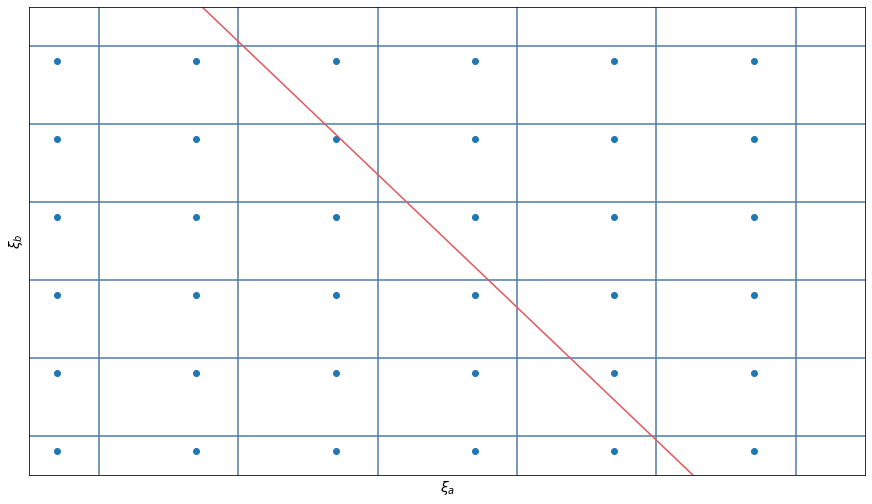

In [4]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

spectrum_size = [res_a / size_a, res_b / size_b]
n_replicas = 6

ax.set_xlabel(r'$\xi_a$', fontsize=14)
ax.set_ylabel(r'$\xi_b$', fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-n_replicas*spectrum_size[0]/2, n_replicas*spectrum_size[0]/2)
ax.set_ylim(-n_replicas*spectrum_size[1]/2, n_replicas*spectrum_size[1]/2)

ax.plot(np.repeat(compute_coordinates(n_replicas, spectrum_size[0]), 3), np.tile([-1000.0, 1000.0, np.nan], n_replicas), color='lfd:signal')
ax.plot(np.tile([-1000.0, 1000.0, np.nan], n_replicas), np.repeat(compute_coordinates(n_replicas, spectrum_size[1]), 3), color='lfd:signal')
ax.scatter(np.repeat(compute_coordinates(n_replicas, spectrum_size[0]), n_replicas) - spectrum_size[0]*0.3,
           np.tile(compute_coordinates(n_replicas, spectrum_size[1]), n_replicas) - spectrum_size[1]*0.2)

ax.plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
pass

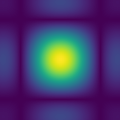

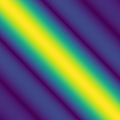

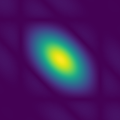

  0%|          | 0/1600 [00:00<?, ?it/s]

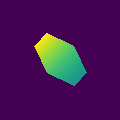

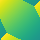

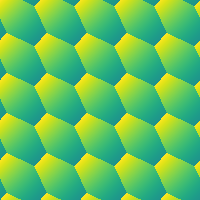

In [5]:
xi_a = 3*fft.fftfreq(3*res_a).astype(np.float32)[:, np.newaxis]
xi_b = 3*fft.fftfreq(3*res_b).astype(np.float32)[np.newaxis, :]

xi_r, xi_p = frequency_display_to_eye(xi_a, xi_b, z_r, z_a, z_b, z_f)

sinc_ab = np.sinc(xi_a) * np.sinc(xi_b)
sinc_rp = np.sinc(xi_p)
imp = np.abs(sinc_ab * sinc_rp)

display_image(fft.fftshift(np.abs(sinc_ab)))
display_image(fft.fftshift(np.abs(sinc_rp)))
display_image(fft.fftshift(imp))

imp_mask = np.zeros_like(imp)
imp_idx = np.zeros((res_a, res_b, 2), dtype=np.int32)

for idx_a, idx_b in tqdm(np.ndindex((res_a, res_b)), total=res_a*res_b, leave=False):
    imp_idx[idx_a, idx_b] = np.array(np.unravel_index(np.argmax(imp[idx_a::res_a, idx_b::res_b]), (3, 3))) * [res_a, res_b] + [idx_a, idx_b]

imp_mask[imp_idx[...,0], imp_idx[...,1]] = 1

imp_color = (-xi_a + 3) * (xi_b + 3)

display_image(fft.fftshift(imp_mask * imp_color))
display_image(fft.fftshift(imp_color[imp_idx[...,0], imp_idx[...,1]]))
display_image(np.tile(fft.fftshift(imp_color[imp_idx[...,0], imp_idx[...,1]]), (5, 5)))

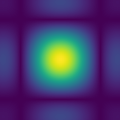

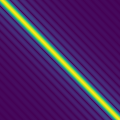

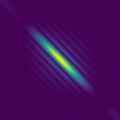

  0%|          | 0/1600 [00:00<?, ?it/s]

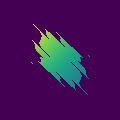

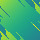

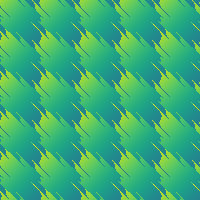

In [6]:
xi_a = 3*fft.fftfreq(3*res_a).astype(np.float32)[:, np.newaxis]
xi_b = 3*fft.fftfreq(3*res_b).astype(np.float32)[np.newaxis, :]

xi_r, xi_p = frequency_display_to_eye(xi_a, xi_b, z_r, z_a, z_b, z_f)

sinc_ab = np.sinc(xi_a) * np.sinc(xi_b)
sinc_rp = np.sinc(xi_p * pupil_diameter)
imp = np.abs(sinc_ab * sinc_rp)

display_image(fft.fftshift(np.abs(sinc_ab)))
display_image(fft.fftshift(np.abs(sinc_rp)))
display_image(fft.fftshift(imp))

imp_mask = np.zeros_like(imp)
imp_idx = np.zeros((res_a, res_b, 2), dtype=np.int32)

for idx_a, idx_b in tqdm(np.ndindex((res_a, res_b)), total=res_a*res_b, leave=False):
    imp_idx[idx_a, idx_b] = np.array(np.unravel_index(np.argmax(imp[idx_a::res_a, idx_b::res_b]), (3, 3))) * [res_a, res_b] + [idx_a, idx_b]

imp_mask[imp_idx[...,0], imp_idx[...,1]] = 1

imp_color = (-xi_a + 3) * (xi_b + 3)

display_image(fft.fftshift(imp_mask * imp_color))
display_image(fft.fftshift(imp_color[imp_idx[...,0], imp_idx[...,1]]))
display_image(np.tile(fft.fftshift(imp_color[imp_idx[...,0], imp_idx[...,1]]), (5, 5)))

In [7]:
xi_a = 3*fft.fftfreq(3*res_a).astype(np.float32)[:, np.newaxis]
xi_b = 3*fft.fftfreq(3*res_b).astype(np.float32)[np.newaxis, :]

xi_r, xi_p = frequency_display_to_eye(xi_a, xi_b, z_r, z_a, z_b, z_f)

sinc_ab = np.sinc(xi_a) * np.sinc(xi_b)
sinc_aabb = sinc_ab[:, np.newaxis, :, np.newaxis] * sinc_ab[np.newaxis, :, np.newaxis, :]
sinc_rp = np.sinc(xi_p * pupil_diameter)
imp_ab = np.abs(sinc_ab * sinc_rp)
imp_aabb = imp_ab[:, np.newaxis, :, np.newaxis] * imp_ab[np.newaxis, :, np.newaxis, :]

imp_idx = np.zeros((res_a, res_a, res_b, res_b, 4), dtype=np.int32)

for idx_xa, idx_ya, idx_xb, idx_yb in tqdm(np.ndindex((res_a, res_a, res_b, res_b)), total=(res_a*res_b)**2, leave=False):
    imp_idx[idx_xa, idx_ya, idx_xb, idx_yb] = np.array(np.unravel_index(np.argmax(imp_aabb[idx_xa::res_a, idx_ya::res_a, idx_xb::res_b, idx_yb::res_b]), (3, 3, 3, 3))) * [res_a, res_a, res_b, res_b] + [idx_xa, idx_ya, idx_xb, idx_yb]

unsinc_filter = np.reciprocal(sinc_aabb[imp_idx[...,0], imp_idx[...,1], imp_idx[...,2], imp_idx[...,3]])

print(np.amin(unsinc_filter), np.amax(unsinc_filter))
print_size(unsinc_filter)

  0%|          | 0/2560000 [00:00<?, ?it/s]

1.0 319.163
(40, 40, 40, 40) float32 | total size: 0.0095367431640625 GiB


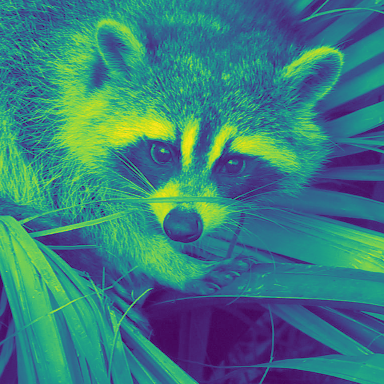

(384, 384) uint8 | total size: 0.0001373291015625 GiB


In [8]:
scene_image = misc.face(True).T[-769:-1:2, ::-2]
display_image(scene_image)
print_size(scene_image)

In [9]:
%%time
print('Oversampling the light field signal...')

oversampled_signal = sample_2d_scene(scene_image, res_r, 3*res_a, 3*res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f)

print_size(oversampled_signal)

Oversampling the light field signal...
(120, 120, 120, 120) uint8 | total size: 0.19311904907226562 GiB
Wall time: 738 ms


In [10]:
%%time
print('Downsampling the light field signal...')

downsampled_signal = decimate_lf(oversampled_signal, 3)

print_size(downsampled_signal)

Downsampling the light field signal...
(40, 40, 40, 40) uint8 | total size: 0.002384185791015625 GiB
Wall time: 0 ns


In [11]:
%%time
print('Unsinc the oversampled light field signal...')

sinc_a = np.sinc(3*fft.fftfreq(3*res_a))[:, np.newaxis, np.newaxis, np.newaxis] * np.sinc(3*fft.fftfreq(3*res_a))[np.newaxis, :, np.newaxis, np.newaxis]
sinc_b = np.sinc(3*fft.fftfreq(3*res_b))[np.newaxis, np.newaxis, :, np.newaxis] * np.sinc(3*fft.fftfreq(3*res_b))[np.newaxis, np.newaxis, np.newaxis, :]

unsinc_oversampled_signal = np.maximum(np.real(fft.ifftn(fft.fftn(oversampled_signal.astype(np.float32)) * np.clip(np.reciprocal(sinc_a * sinc_b), -16.0, 16.0))), 0.0)
unsinc_oversampled_signal = (unsinc_oversampled_signal * 255 / np.amax(unsinc_oversampled_signal)).astype(np.uint8)

print_size(unsinc_oversampled_signal)

Unsinc the oversampled light field signal...
(120, 120, 120, 120) uint8 | total size: 0.19311904907226562 GiB
Wall time: 25.9 s


In [12]:
%%time
print('Unsinc the downsampled light field signal...')

sinc_a = np.sinc(fft.fftfreq(res_a))[:, np.newaxis, np.newaxis, np.newaxis] * np.sinc(fft.fftfreq(res_a))[np.newaxis, :, np.newaxis, np.newaxis]
sinc_b = np.sinc(fft.fftfreq(res_b))[np.newaxis, np.newaxis, :, np.newaxis] * np.sinc(fft.fftfreq(res_b))[np.newaxis, np.newaxis, np.newaxis, :]

unsinc_downsampled_signal = np.maximum(np.real(fft.ifftn(fft.fftn(downsampled_signal.astype(np.float32)) * np.reciprocal(sinc_a * sinc_b))), 0.0)
unsinc_downsampled_signal = (unsinc_downsampled_signal * 255 / np.amax(unsinc_downsampled_signal)).astype(np.uint8)

print_size(unsinc_downsampled_signal)

Unsinc the downsampled light field signal...
(40, 40, 40, 40) uint8 | total size: 0.002384185791015625 GiB
Wall time: 251 ms


In [13]:
%%time
print('Unsinc 2.0 the downsampled light field signal...')

unsinc2_downsampled_signal = np.maximum(np.real(fft.ifftn(fft.fftn(downsampled_signal.astype(np.float32)) * unsinc_filter)), 0.0)
unsinc2_downsampled_signal = (unsinc2_downsampled_signal * 255 / np.amax(unsinc2_downsampled_signal)).astype(np.uint8)

print_size(unsinc2_downsampled_signal)

Unsinc 2.0 the downsampled light field signal...
(40, 40, 40, 40) uint8 | total size: 0.002384185791015625 GiB
Wall time: 225 ms


In [14]:
%%time
print('Computing retinal image from oversampled signal...')

#retinal_image = compute_retinal_image(oversampled_signal, res_r, 3*res_a, 3*res_b, size_r, size_a, size_b, 3, 3, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

#display_image(retinal_image)

Computing retinal image from oversampled signal...
Wall time: 0 ns


Computing retinal image from downsampled signal...


  0%|          | 0/147456 [00:00<?, ?it/s]

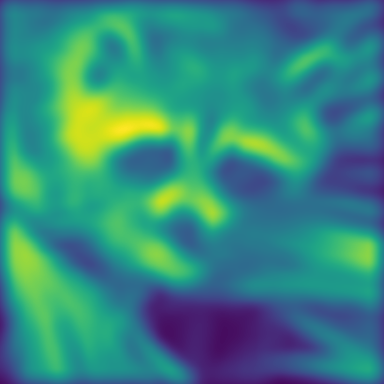

Wall time: 1min 59s


In [15]:
%%time
print('Computing retinal image from downsampled signal...')

retinal_image = compute_retinal_image(downsampled_signal, res_r, res_a, res_b, size_r, size_a, size_b, 1, 1, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

display_image(retinal_image)

In [16]:
%%time
print('Computing retinal image from unsinc oversampled signal...')

#retinal_image = compute_retinal_image(unsinc_oversampled_signal, res_r, 3*res_a, 3*res_b, size_r, size_a, size_b, 3, 3, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

#display_image(retinal_image)

Computing retinal image from unsinc oversampled signal...
Wall time: 997 µs


Computing retinal image from unsinc downsampled signal...


  0%|          | 0/147456 [00:00<?, ?it/s]

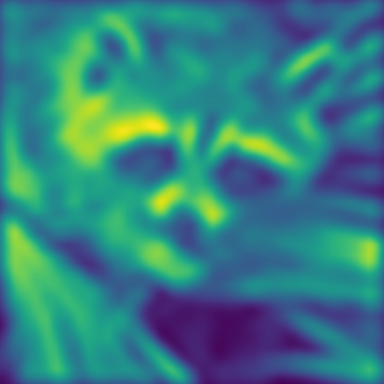

Wall time: 2min 1s


In [17]:
%%time
print('Computing retinal image from unsinc downsampled signal...')

retinal_image = compute_retinal_image(unsinc_downsampled_signal, res_r, res_a, res_b, size_r, size_a, size_b, 1, 1, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

display_image(retinal_image)

Computing retinal image from unsinc 2.0 downsampled signal...


  0%|          | 0/147456 [00:00<?, ?it/s]

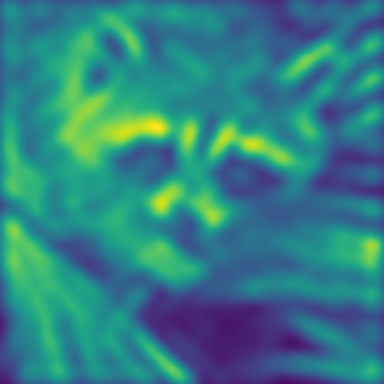

Wall time: 1min 58s


In [18]:
%%time
print('Computing retinal image from unsinc 2.0 downsampled signal...')

retinal_image = compute_retinal_image(unsinc2_downsampled_signal, res_r, res_a, res_b, size_r, size_a, size_b, 1, 1, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

display_image(retinal_image)